# Implement quantitative trading for stocks using DQN 

Dong sikai，Fu zhongchen

In [7]:
!pip install gym matplotlib

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.0 MB 1.5 MB/s eta 0:00:05
   ------- -------------------------------- 1.6/8.0 MB 2.6 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/8.0 MB 3.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.0 MB 3.4 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.0 MB 4.1 MB/s eta 0:00:01
   ------------------------------ --------- 6.0/8.0 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.0 MB 4.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 4.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.2 MB 11.8 MB/s eta 0:00:01
   ------------------------------------

In [8]:
from gym import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt


In [46]:
# Create the environment
class StockTradingEnvironment():
    def __init__(self, csv_file):  
        self.data = pd.read_csv(csv_file)
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,))  # Dimension of the state space
        self.action_space = spaces.Discrete(3)  # Dimension of the action space: 0 represents sell, 1 represents buy, 2 represents hold
        self.current_step = 0  # Current time step
        self.trade_amount = 0
        self.cash_balance = 100000  # Initial cash balance
        self.stock_quantity = 0  # Initial stock holdings set to 0
        self.stock_price = self.data.iloc[0]['open']  # Initial stock price
        self.total_assets = self.cash_balance  # Initial total assets
        self.previous_cash_balance = 0  # Cash balance from the previous time step
        self.previous_stock_quantity = 0  # Stock quantity from the previous time step
        self.previous_price = 0  # Price from the previous time step

    def reset(self):  # Reset the environment to its initial state
        self.current_step = 0
        self.trade_amount = 0
        self.cash_balance = 100000
        self.stock_quantity = 0
        self.stock_price = self.data.iloc[0]['open']
        self.total_assets = self.cash_balance
        self.previous_cash_balance = 0  # Cash balance from the previous time step
        self.previous_stock_quantity = 0  # Stock quantity from the previous time step
        self.previous_price = 0  # Price from the previous time step

        return self._get_observation()

    def step(self, action):  # Execute an action and observe the next state, reward, and whether the episode is over
        self._take_action(action)
        self.current_step += 1
        reward = self._get_reward()
        done = self.current_step >= len(self.data) - 1
        return self._get_observation(), reward, done, {}

    def _get_observation(self):  # get_state: Observations of the environment
        current_price = self.data.iloc[self.current_step]['close']
        observation = [current_price, self.stock_quantity, 0, 0, 0, 0]  # Extend the observation to length 6 to avoid errors
        return torch.tensor(observation, dtype=torch.float)  # Return the observation as a tensor

    def _take_action(self, action):  # Action space
        trade_amount = 0
        current_price = self.data.iloc[self.current_step]['close']
        
        if action == 0:  # Sell
            trade_amount = int(self.stock_quantity * 0.5)
            if trade_amount > 0:
                self.cash_balance += trade_amount * current_price  # Total assets
                self.stock_quantity -= trade_amount

        elif action == 1:  # Buy
            trade_amount = int(self.cash_balance / (2 * current_price))
            if trade_amount > 0:
                self.cash_balance -= trade_amount * current_price
                self.stock_quantity += trade_amount

        # print("action:  ", action)
        # print("trade_amount:  ", trade_amount)
        self.trade_amount = trade_amount

        # Update the state from the previous time step
        self.previous_cash_balance = self.cash_balance
        self.previous_stock_quantity = self.stock_quantity
        self.previous_price = current_price

    def _get_reward(self):
        current_price = self.data.iloc[self.current_step]['close']
        current_total_assets = self.cash_balance + self.stock_quantity * current_price
        previous_total_assets = self.previous_cash_balance + self.previous_stock_quantity * self.previous_price
        reward = current_total_assets - previous_total_assets
        return reward



In [47]:
# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration factor
        self.epsilon_decay = 0.995  # Decay rate of the exploration factor
        self.epsilon_min = 0.01  # Minimum value of the exploration factor
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.criterion = nn.MSELoss()

    def decay_epsilon(self):  # When epsilon=1, exploration is completely random
        self.epsilon *= self.epsilon_decay

    def remember(self, state, action, reward, next_state, done):  # Experience replay
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        q_values = self.model(state)
        return torch.argmax(q_values).item()
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = state.to(device)
            next_state = next_state.to(device)

        # Calculate target Q value
        target = reward
        if not done:
            next_q_values = self.model(next_state).detach()
            target += self.gamma * torch.max(next_q_values).item()

        # Get current Q values
        q_values = self.model(state)
        target_q_values = q_values.clone()
        target_q_values[action] = target  # Update Q value for the corresponding action

        # Fix loss calculation
        # Ensure q_values and target_q_values have consistent shapes
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


Using device: cuda
Model device: cuda:0
State device: cuda:0
Episode 1, Total Reward: 38243.910507202076
Episode 2, Total Reward: 42212.05147552502
Episode 3, Total Reward: 69018.7011680603
Episode 4, Total Reward: 58360.72782135029
Episode 5, Total Reward: 54402.47085571286
Episode 6, Total Reward: 64719.05396652216
Episode 7, Total Reward: 40440.664299011216
Episode 8, Total Reward: 97871.1780014037
Episode 9, Total Reward: 86602.38876724233
Episode 10, Total Reward: 6573.331916808995
Episode 11, Total Reward: 52657.47383117679
Episode 12, Total Reward: 54571.64199447632
Episode 13, Total Reward: 88992.84680175774
Episode 14, Total Reward: 142470.71404647818
Episode 15, Total Reward: 73763.5803909302
Episode 16, Total Reward: 118569.415222168
Episode 17, Total Reward: 72905.22718048103
Episode 18, Total Reward: 67517.07838439944
Episode 19, Total Reward: 87105.9808311462
Episode 20, Total Reward: 75460.1437187195
Episode 21, Total Reward: 111333.72346496586
Episode 22, Total Reward: 

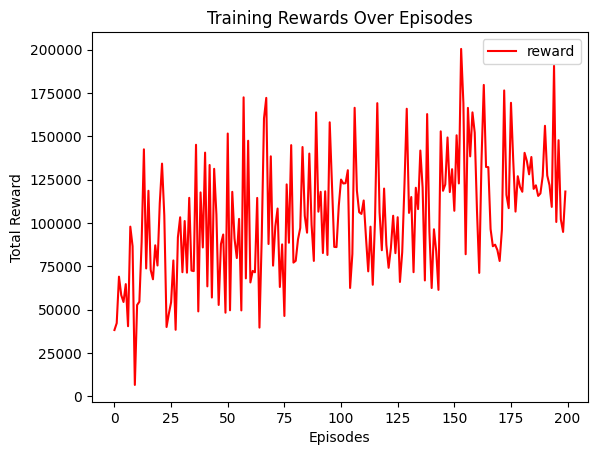

In [51]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the environment and model
env = StockTradingEnvironment('train_data.csv')
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

# Move the model to the device
agent.model.to(device)

print(f"Model device: {next(agent.model.parameters()).device}")
print(f"State device: {state.device}")


# Training loop
rewards = []
for episode in range(200):
    state = env.reset().to(device)  # Ensure the state is on the device
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)  # The agent selects an action
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.to(device)  # Move the next state to the device
        agent.remember(state, action, reward, next_state, done)  # Store the experience
        state = next_state  # Update the current state
        agent.replay(32)  # Sample from the memory pool and train
        total_reward += reward

    rewards.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")
    agent.decay_epsilon()  # Decay epsilon

plt.plot(rewards, '-', c='r', label='reward')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Rewards Over Episodes')
plt.legend()
plt.show()
